In [1]:
import xarray as xr
import ghibtools as gh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pingouin
from compute_rri import ecg_job
from params import *
from bibliotheque import get_pos
import physio
from configuration import base_folder
import os

In [2]:
concat = []
for run_key in run_keys:
    participant,session = run_key.split('_')
    peaks = ecg_job.get(run_key)['ecg_peaks']
    metrics = physio.compute_ecg_metrics(peaks, srate)
    df = metrics.to_frame().T
    df.insert(0 , 'session', session)
    df.insert(0 , 'participant', participant)
    concat.append(df)
hrv = pd.concat(concat)

ecg is processing ('P19_baseline',)
ecg is processing ('P19_music',)
ecg is processing ('P19_odor',)
ecg is processing ('P20_baseline',)
ecg is processing ('P20_music',)
ecg is processing ('P20_odor',)


In [3]:
metrics = ['HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad',
       'HRV_CV', 'HRV_MCV', 'HRV_Asymmetry', 'HRV_RMSSD']
indexes = ['participant','session']

In [4]:
def ratio_baseline(df, indexes, metrics):
    odor = df[df['session'] == 'odor'].set_index(indexes)
    music = df[df['session'] == 'music'].set_index(indexes)
    baseline = df[df['session'] == 'baseline'].set_index(indexes)
    
    data_odor = odor.values / baseline.values
    data_music = music.values / baseline.values
    
    df_odor = pd.DataFrame(data = data_odor, columns = metrics, index = odor.index)
    df_music = pd.DataFrame(data = data_music, columns = metrics, index = music.index)
    
    return pd.concat([df_odor, df_music]).reset_index()

In [5]:
hrv_baselined = ratio_baseline(hrv, indexes, metrics)

In [6]:
hrv.columns

Index(['participant', 'session', 'HRV_Mean', 'HRV_SD', 'HRV_Median', 'HRV_Mad',
       'HRV_CV', 'HRV_MCV', 'HRV_Asymmetry', 'HRV_RMSSD'],
      dtype='object')

In [7]:
hrv

,participant,session,HRV_Mean,HRV_SD,HRV_Median,HRV_Mad,HRV_CV,HRV_MCV,HRV_Asymmetry,HRV_RMSSD
0,P01,baseline,709.589588,44.237498,709.0,42.995464,0.062342,0.060642,-0.589588,28.034497
0,P01,music,736.550761,49.575469,733.0,36.323754,0.067308,0.049555,-3.550761,43.943494
0,P01,odor,762.566434,61.095175,760.0,48.925873,0.080118,0.064376,-2.566434,45.687063
0,P02,baseline,750.078849,85.528176,744.0,97.851746,0.114026,0.131521,-6.078849,57.234754
0,P02,music,750.314143,86.288657,740.0,88.956133,0.115003,0.120211,-10.314143,54.681626
...,...,...,...,...,...,...,...,...,...,...
0,P20,music,752.943467,52.486304,740.0,45.960669,0.069708,0.062109,-12.943467,47.215124
0,P20,odor,759.812421,52.986813,749.0,47.443271,0.069737,0.063342,-10.812421,48.926600
0,P21,baseline,893.410448,52.706426,902.0,41.512862,0.058995,0.046023,8.589552,36.172668
0,P21,music,889.774146,59.760688,897.0,54.856282,0.067164,0.061155,7.225854,40.228958


/tmp/ipykernel_34509/525081435.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(hrv.corr('spearman'), annot = True, cmap = 'seismic', vmin = -1, vmax = 1, ax=ax)


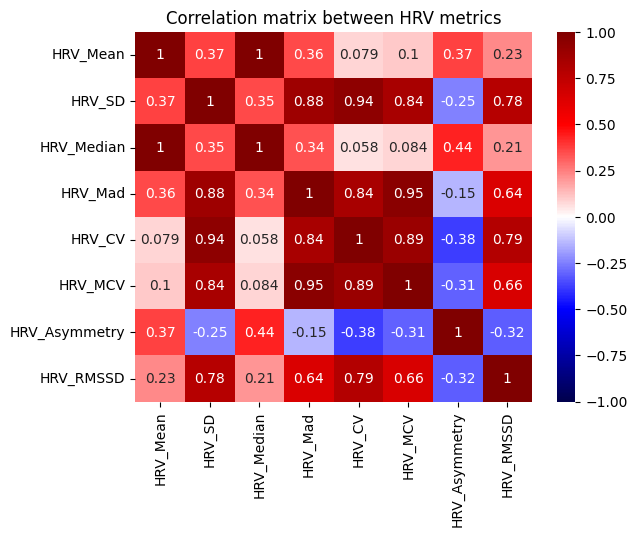

In [8]:
fig, ax = plt.subplots()
sns.heatmap(hrv.corr('spearman'), annot = True, cmap = 'seismic', vmin = -1, vmax = 1, ax=ax)
ax.set_title('Correlation matrix between HRV metrics')
file = base_folder / 'Figures' / 'HRV' / 'corr_matrix_hrv.png'
fig.savefig(file, bbox_inches = 'tight')
fig.show()

/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d
/home/valentin.ghibaudo/.virtualenvs/py3.10_nodegpu/lib/python3.10/site-packages/pingouin/distribution.py:1006: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


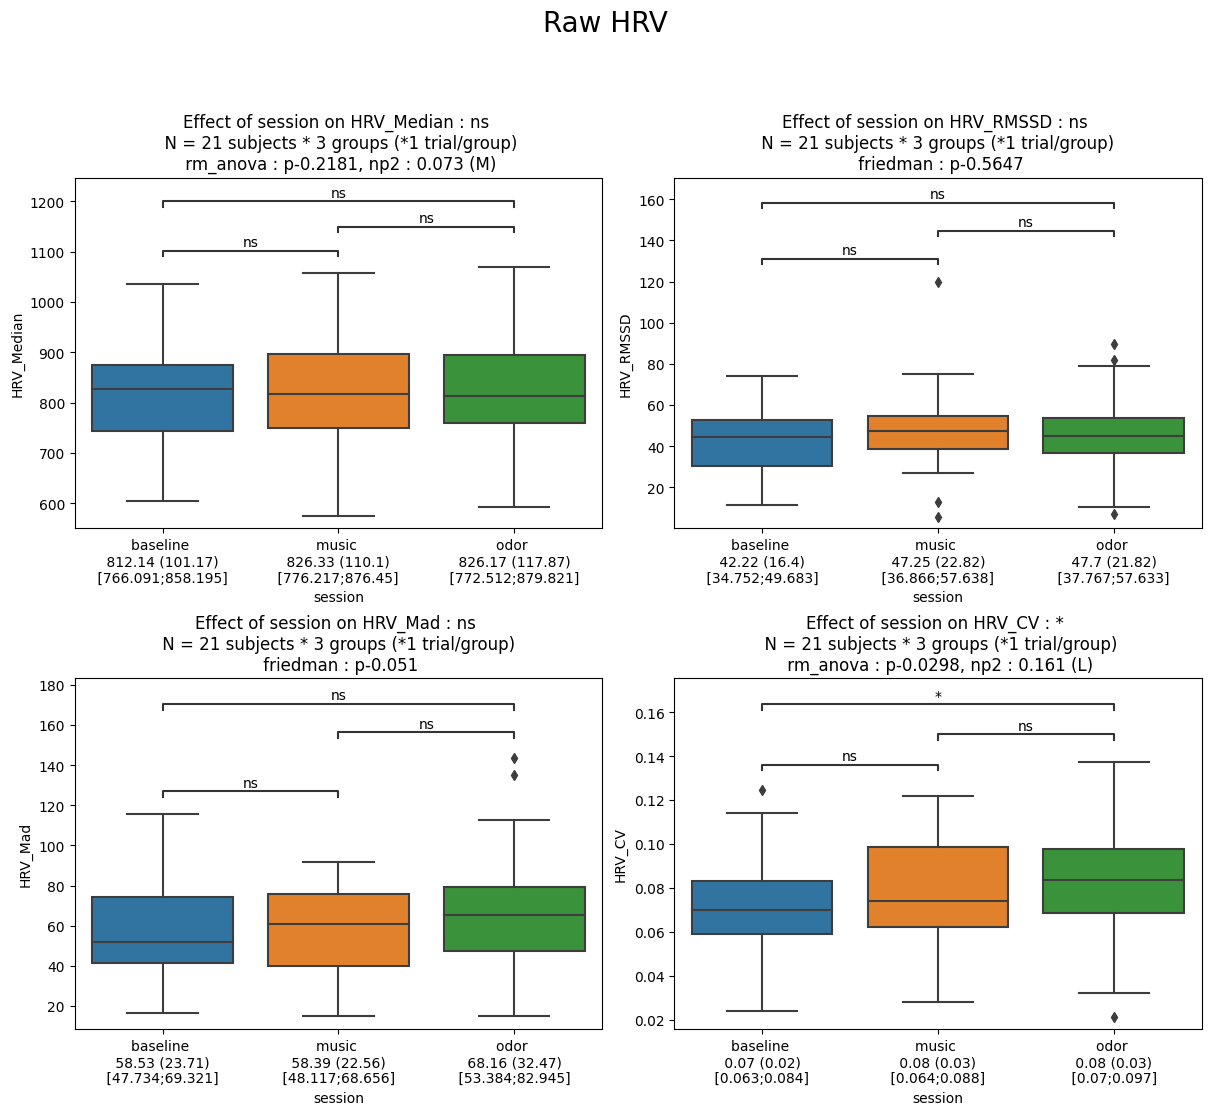

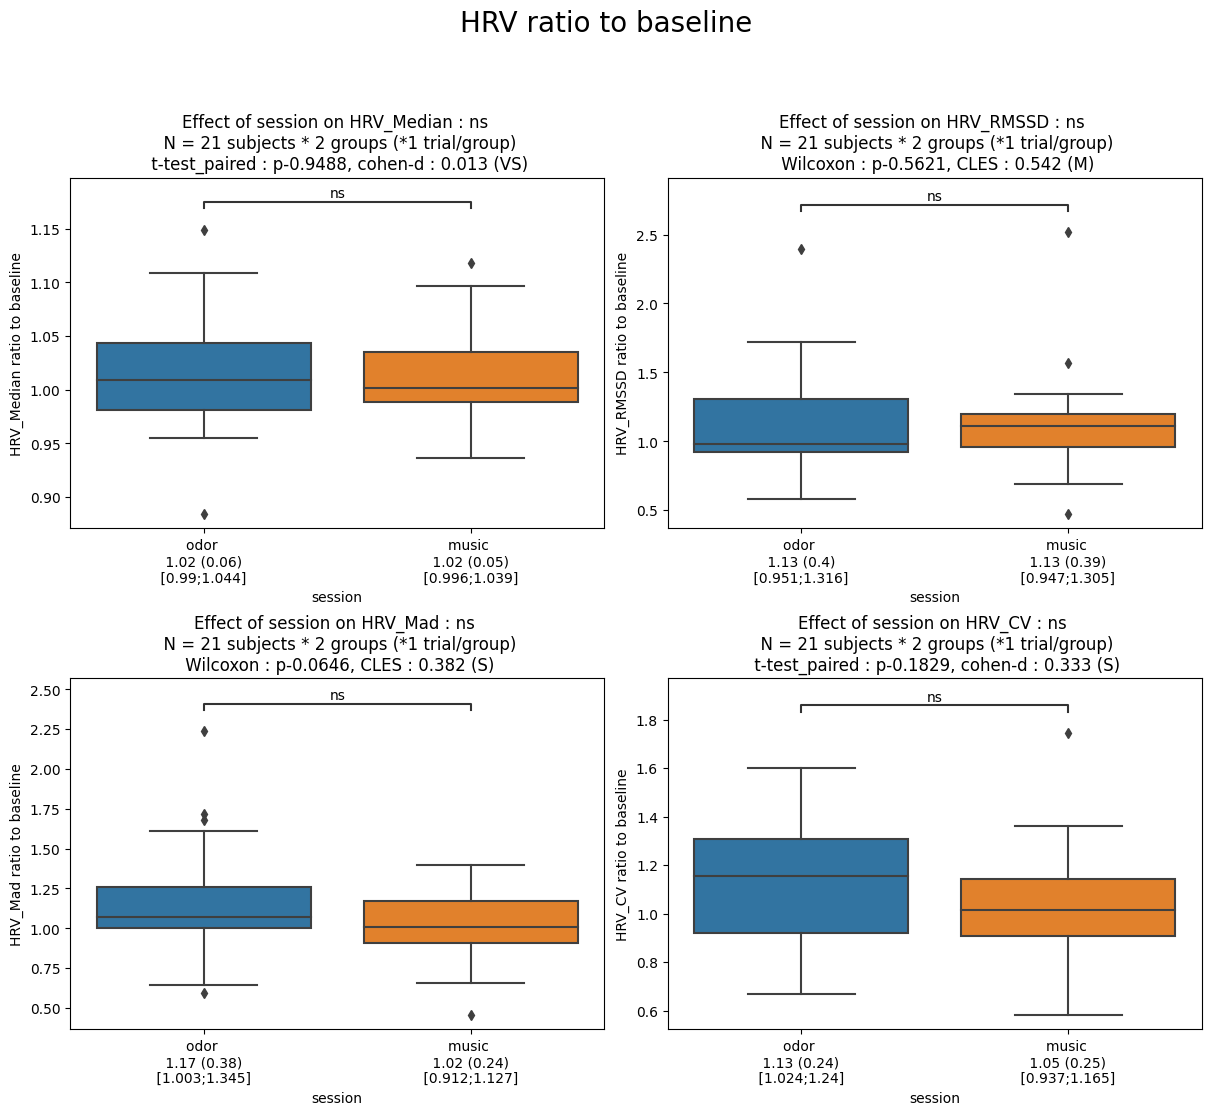

In [9]:
interesting_metrics = ['HRV_Median','HRV_RMSSD','HRV_Mad','HRV_CV']

nrows = 2
ncols = 2
plot_metrics = np.array(interesting_metrics).reshape(nrows, ncols)

for suptitle, df in zip(['Raw HRV','HRV ratio to baseline'],[hrv, hrv_baselined]):
    
    fig, axs = plt.subplots(nrows, ncols, figsize = (12,10), constrained_layout = True)
    fig.suptitle(suptitle, fontsize = 20, y = 1.1)
    
    for c in range(ncols):
        for r in range(nrows):
            ax = axs[r,c]
            metric = plot_metrics[r,c]
            
            gh.auto_stats(df=df, predictor = 'session', outcome = metric, design = 'within', subject = 'participant', ax=ax)
            if 'ratio' in suptitle:
                ax.set_ylabel(ax.get_ylabel() + ' ratio to baseline')
    file = base_folder / 'Figures' / 'HRV' / f'{suptitle}.png'

    fig.savefig(file, bbox_inches = 'tight')
    fig.show()